# Toward Optimal Retrieval: Dynamically Choosing `k` in Vector-Based Search


## 📚 Introduction to Retrieval-Augmented Generation (RAG)

### What is RAG?

**Retrieval-Augmented Generation (RAG)** is a hybrid architecture that combines the strengths of **retrieval-based** systems and **generative language models**. Instead of relying solely on a language model's internal parameters to answer questions or generate content, RAG explicitly augments the generation process by retrieving relevant external knowledge.

The RAG architecture was introduced to address limitations in traditional language models, especially their tendency to **"hallucinate"** or produce incorrect information due to lack of grounding in external knowledge sources.

---

### 🔍 Why Use RAG?

Pre-trained language models (e.g., GPT, LLaMA, etc.) are trained on massive datasets but are inherently static:

- They cannot learn new knowledge after training unless fine-tuned.
- Their knowledge is limited to their training cutoff.
- They struggle with domain-specific or long-tail queries.

RAG solves these problems by:
- **Fetching real-time or up-to-date information** from external sources like documents, databases, or knowledge graphs.
- **Reducing hallucinations** by grounding responses in retrieved context.
- **Improving performance** on specialized tasks or domains without retraining the model.

---

### 🧠 How Does RAG Work?

The RAG pipeline generally consists of **three main components**:

1. **Encoder-based Retriever**
   - Given an input query, a retriever fetches the top-*k* most relevant documents from a vectorDB (e.g., FAISS, ChromaDB) using vector similarity search.
   - These documents serve as an external knowledge source.

2. **Contextual Fusion**
   - The retrieved documents are passed alongside the query into a language model (e.g., a transformer decoder) to generate an informed response.
   - This can be done by concatenating the documents and query into a single prompt.

3. **Generator**
   - A generative model (like GPT or BART) produces the final output based on the augmented input (query + retrieved knowledge).

```text
User Query → Retriever → Top-k Documents → Generator → Final Answer


## Setup -  Lets create a simple RAG Agent

### 🔧 1. Install Dependencies

In [121]:
!pip install langchain chromadb langchain-community langchain-openai tiktoken python-dotenv datasets ipywidgets rapidfuzz seaborn sentence-transformers

### 🔐 2. Set API Key

In [122]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Access the key
api_key = os.getenv("OPENAI_API_KEY")

# Set it as environment variable for OpenAI
os.environ["OPENAI_API_KEY"] = api_key

### 3. Load HotpotQA Dataset

In [123]:
from datasets import load_dataset

# Load HotpotQA dataset
hotpot = load_dataset("hotpot_qa", "fullwiki")
hotpot_qa_dataset = hotpot["validation"]

# Filter for short (1–2 word) answers
def is_short_answer(example):
    answer = example["answer"]
    return isinstance(answer, str) and 1 <= len(answer.strip().split()) <= 2

short_answer_dataset = hotpot_qa_dataset.filter(is_short_answer)
print(f"✅ Filtered dataset: {len(short_answer_dataset)} questions with 1–2 word answers.")


/opt/homebrew/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for hotpot_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hotpot_qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


✅ Filtered dataset: 4702 questions with 1–2 word answers.


### 🧠 Step 4: Create the documents from the dataset

In [124]:
from langchain_core.documents import Document

def extract_hotpot_documents(dataset):
    docs = []
    seen_passages = set()

    for example in dataset:
        titles = example["context"]["title"]
        sentence_lists = example["context"]["sentences"]

        for title, sentences in zip(titles, sentence_lists):
            content = " ".join(sentences).strip()
            key = (title, content)
            if content and key not in seen_passages:
                doc = Document(
                    page_content=content,
                    metadata={"source": title}
                )
                docs.append(doc)
                seen_passages.add(key)
    return docs

documents = extract_hotpot_documents(short_answer_dataset)

print(f"Extracted {len(documents)} documents.")


Extracted 43507 documents.


### Step 5: Create embeddings and store in ChromaDB

In [125]:
import os
import shutil
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

embedding_model = OpenAIEmbeddings()

def build_vectorstore(documents, persist_dir="./chroma_db", force_rebuild=False):
    """
    Builds or loads a Chroma vectorstore from the given documents.

    Args:
        documents: List of Langchain Document objects.
        persist_dir: Directory to persist or load the vectorstore.
        force_rebuild: If True, deletes and rebuilds the vectorstore.

    Returns:
        vectorstore (Chroma), valid_docs (list)
    """
    if os.path.exists(persist_dir) and not force_rebuild:
        print(f"🔁 Loading existing vectorstore from '{persist_dir}'...")
        vectorstore = Chroma(persist_directory=persist_dir, embedding_function=embedding_model)
        stored = vectorstore._collection.get(include=["documents"])
        valid_docs = [Document(page_content=doc) for doc in stored["documents"]]
        print(f"✅ Loaded existing vectorstore with {len(valid_docs)} documents.")
        return vectorstore, valid_docs

    # Otherwise, rebuild the vectorstore
    print("📦 Building new Chroma vectorstore...")

    valid_docs = [doc for doc in documents if doc.page_content and doc.page_content.strip()]
    if not valid_docs:
        raise ValueError("❌ No valid documents found to build the vectorstore.")

    if os.path.exists(persist_dir):
        print(f"🧹 Removing old vectorstore at '{persist_dir}'...")
        shutil.rmtree(persist_dir)

    vectorstore = Chroma.from_documents(
        documents=valid_docs,
        embedding=embedding_model,
        persist_directory=persist_dir
    )
    vectorstore.persist()
    print(f"✅ Vectorstore built and persisted with {len(valid_docs)} documents.")
    vectorstore.as_retriever()
    return vectorstore, valid_docs

vectorstore, embedding = build_vectorstore(documents)

🔁 Loading existing vectorstore from './chroma_db'...
✅ Loaded existing vectorstore with 43509 documents.


### 🤖 Step 6: Define the RAG Agent

In [126]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import Document
from typing import Dict, List


class CustomRAGAgent:
    def __init__(self, retriever, llm, prompt):
        self.retriever = retriever
        self.llm = llm
        self.prompt = prompt

    def invoke(self, inputs: Dict[str, str], k) -> Dict:
        question = inputs["question"]
        docs: List[Document] = self.retriever.get_relevant_documents(question, k=k)
        summaries = "\n\n".join(doc.page_content for doc in docs)

        # Format the full prompt
        messages = self.prompt.format_messages(question=question, summaries=summaries)
        full_prompt_str = "\n\n".join([f"{msg.type.upper()}:\n{msg.content}\n" for msg in messages])

        # Get the LLM's response
        response = self.llm.invoke(messages)

        return {
            "answer": response.content,
            "source_documents": docs,
            "full_prompt": full_prompt_str
        }


def create_rag_agent():
    retriever = vectorstore.as_retriever()
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.2, max_tokens=8000)

    system_template = (
        "You are a Retrieval-Augmented Generation (RAG) agent. "
        "Answer only using the provided context below. "
        "Respond with concise. accurate answers. Use only 1-2 words in your answer.\n\n"
        "Context:\n{summaries}"
    )

    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template("Question: {question}")
    ])

    return CustomRAGAgent(retriever, llm, prompt)


## Simple Example

#### Lets add some custom documents  

In [127]:
# Add our custom documents

existing_docs = vectorstore.similarity_search(
    query="irrelevant dummy text",
    k=100,  # large enough to ensure matches if any exist
    filter={"id": 111111}
)

if not existing_docs:
    print("Adding custom documents")
    yarin = Document(page_content="Yarin's favorite food is Pizza", metadata={"id": 111111, "source": 3201})
    michal = Document(page_content="Michal's favorite food is Croissant",metadata={"id": 111112, "source": 3202})
    vectorstore.add_documents([yarin, michal])
else:
    print("Custom documents already exist")

Custom documents already exist


### 🤖 5.1. Create a RAG agent

In [128]:
# Create RAG agent with k = 1
rag_agent = create_rag_agent()

In [129]:
result = rag_agent.invoke({"question": "what is Yarin's favortie food?"}, k=1)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------\n")
print(result["full_prompt"])

-------------Answer:-------------

Pizza

-------------Full prompt:-------------

SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Yarin's favorite food is Pizza


HUMAN:
Question: what is Yarin's favortie food?



### What about Michal's favorite food?

In [130]:
result = rag_agent.invoke({"question": "what is Michal's favortie food?"}, k=1)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------\n")
print(result["full_prompt"])

-------------Answer:-------------

Croissant

-------------Full prompt:-------------

SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Michal's favorite food is Croissant


HUMAN:
Question: what is Michal's favortie food?



### Lets see if he can answer for both of us

In [131]:
result = rag_agent.invoke({"question": "what are Yarin's and Michal's favortie food?"}, k=1)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------")
print(result["full_prompt"])

-------------Answer:-------------

Pizza

-------------Full prompt:-------------
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Yarin's favorite food is Pizza


HUMAN:
Question: what are Yarin's and Michal's favortie food?



### Thats too bad...

### I guess k=1 is not the best option

### What about k=2 ?

In [132]:
result = rag_agent.invoke({"question": "what are Yarin's and Michal's favortie food?"}, k=2)
print("-------------Answer:-------------\n")
print(result["answer"] + "\n")
print("-------------Full prompt:-------------")
print(result["full_prompt"])

-------------Answer:-------------

Pizza, Croissant

-------------Full prompt:-------------
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Yarin's favorite food is Pizza

Michal's favorite food is Croissant


HUMAN:
Question: what are Yarin's and Michal's favortie food?



# ❗ Problem - Limitations of Static `k` in Vector Similarity Search

## Background

In Retrieval-Augmented Generation (RAG) and other retrieval-based systems, **vector similarity search** is a key operation. Given a query, the system retrieves the top-*k* most similar documents from a vector database using semantic embeddings and similarity metrics (e.g., cosine similarity or dot product).

The parameter **`k`** represents the number of documents to retrieve per query. In most RAG implementations, `k` is set to a **fixed value** (e.g., `k=3` or `k=5`) for all inputs.

While simple and easy to implement, **using a static value of `k` across all inputs introduces several problems** that can negatively impact retrieval relevance, model performance, and computational efficiency.

---

## 🔍 The Core Problem: One-Size-Does-Not-Fit-All

Different user queries or prompts have different levels of complexity, ambiguity, and knowledge requirements. However, a static `k` assumes that **every query benefits equally from the same number of retrieved documents** — which is often not true.

---

## 🔥 Why a Fixed `k` is Suboptimal

### 1. **Under-retrieval (k too small)**
- Important context may be **missed**, especially for complex or vague queries.
- Language model generates **incomplete or hallucinated** responses due to lack of sufficient information.
- Example: A legal or medical question might require 10+ documents to cover relevant information.

### 2. **Over-retrieval (k too large)**
- Irrelevant or noisy documents may dilute the useful context.
- More documents → longer input prompt → higher **token costs** in LLMs.
- May confuse the model, especially when irrelevant docs are included.
- Wastes compute, memory, and latency for simple, narrow queries.

### 3. **No Adaptivity to Query Entropy or Difficulty**
- Not all queries are created equal:
  - Some are **simple and factoid-like** ("What is the capital of Italy?")
  - Others are **ambiguous, multi-faceted, or domain-specific**
- Fixed `k` ignores this variability, leading to suboptimal results in either direction.

---

## 🎯 Research Objective

The goal of this research is to **dynamically determine the optimal value of `k` per query**, based on characteristics of the input or the retrieval results — such as:

- Query entropy or uncertainty
- Query length and type
- Similarity distribution of top retrieved documents
- Historical performance metrics

By intelligently adjusting `k`, we aim to improve:

- Retrieval relevance and precision
- LLM answer quality
- Efficiency and cost-effectiveness of the system

In the next sections, we will explore strategies, algorithms, and evaluation methods for achieving this dynamic retrieval objective.



## 🧪 RAG Evaluation

### 🔍 Evaluation Setup
- **Corpus**: A subset of Wikipedia documents (`rag-mini-wikipedia`, `text-corpus` split).
- **Questions**: Sourced from the `question-answer` split of the same dataset.
- **Model**: `gpt-4o-mini` used via LangChain's `ChatOpenAI`.
- **Retriever**: ChromaDB vectorstore with top-k document retrieval (`k = 1`).
- **Goal**: Compare generated answers to ground-truth answers using fuzzy matching for leniency.

### 🧠 Accuracy Metric
- We use **cosine similarity**
- A prediction is considered correct if its cosine similarity score with the ground truth exceeds a given threshold (e.g. `>= 0.8`).

---


In [133]:
def get_embedding(text: str) -> list[float]:
    """Get embedding"""
    response = embedding_model.embed_query(text)
    return response

def get_all_document_embeddings(vectorstore):
    collection = vectorstore._collection
    stored = collection.get(include=["embeddings", "documents"])

    # List of (id, embedding, document)
    embeddings = stored["embeddings"]  # List of [float]
    documents = stored["documents"]

    return embeddings, documents

hotpot_embeddings, hotpot_documents = get_all_document_embeddings(vectorstore)

In [ ]:
import numpy as np
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_rag_agent_parallel(
    dataset,
    k: int = 3,
    n_questions: int = 10,
    threshold: float = 1.0,
    seed: int = 42,
    max_workers: int = 8,
    dynamic_k_function: callable = None,
    null_distribution=None,
    selected_indices= None,
    alpha: float = 0.05
):
    total_available = len(dataset["question"])
    if selected_indices is None:
        indices = list(range(total_available))
        random.Random(seed).shuffle(indices)
        selected_indices = indices[:n_questions]


    questions = [dataset["question"][i] for i in selected_indices]
    answers = [dataset["answer"][i] for i in selected_indices]

    rag_agent = create_rag_agent()
    results = []
    correct = 0
    evaluated = 0
    all_ks = []

    if dynamic_k_function:
        print(f"\n🔍 Evaluating RAG Agent (with Dynamic k: {dynamic_k_function.__name__})\n")
    else:
        print(f"\n🔍 Evaluating RAG Agent (with fixed k={k})\n")


    def evaluate_single(idx, question, ground_truth):
        question_emb = get_embedding(question)

        if dynamic_k_function:
            sims = cosine_similarity([question_emb], hotpot_embeddings)[0]
            sorted_indices = np.argsort(sims)[::-1]
            doc_embs = [hotpot_embeddings[i] for i in sorted_indices]
            final_k = dynamic_k_function(question_emb, doc_embs, null_distribution, alpha)
        else:
            final_k = k

        all_ks.append(final_k)

        result = rag_agent.invoke({"question": question}, k=final_k)
        prediction = result["answer"]
        source_docs = result.get("source_documents", [])
        full_prompt = result.get("full_prompt")

        similar = cosine_similarity([get_embedding(prediction)], [get_embedding(ground_truth)])[0][0]

        return {
            "index": idx,
            "question": question,
            "ground_truth": ground_truth,
            "prediction": prediction,
            "similar": similar,
            "status": "correct" if similar >= threshold else "incorrect",
            "k": final_k,
            "retrieved_docs": [
                {"source": doc.metadata.get("source", None), "content": doc.page_content} for doc in source_docs
            ],
            "full_prompt": full_prompt
        }

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(evaluate_single, idx, q, a)
            for idx, (q, a) in enumerate(zip(questions, answers))
        ]

        for future in tqdm(as_completed(futures), total=n_questions, desc="Evaluating"):
            log = future.result()
            results.append(log)
            if log["status"] == "correct":
                correct += 1
            if log["status"] in {"correct", "incorrect"}:
                evaluated += 1

    results.sort(key=lambda x: x["index"])

    for log in results:
        print(f"\n[{log['index']}] {'✅' if log['status'] == 'correct' else '❌'} {log['status'].upper()}")
        print(f"Question: {log['question']}")
        print(f"Prediction: {log['prediction']}")
        print(f"Ground Truth: {log['ground_truth']}")
        print(f"Similarity Score: {log['similar']:.4f}")
        print(f"k used: {log['k']} {'(Dynamic k)' if dynamic_k_function else '(Fixed k)'}")
        print(f"📨 Full Prompt:\n{log['full_prompt']}")
        print("-" * 60)

    accuracy = correct / evaluated if evaluated > 0 else 0.0

    print(f"\n🎯 Final Accuracy k = {k} on {evaluated} evaluated questions: {accuracy:.2%}")

    return {
        "n_questions": n_questions,
        "accuracy": accuracy,
        "evaluated": evaluated,
        "correct": correct,
        "logs": results,
        "seed": seed,
        "selected_indices": selected_indices,
        "ks": all_ks,  # <- So plotting code works,
        "retrieved_docs": log['retrieved_docs']
    }


In [135]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_accuracy_comparison(results: list):
    """
    Plot accuracy vs. individual dynamic `k` values.

    Args:
        results: List of dicts returned from evaluate_rag_agent_parallel().
    """
    grouped = defaultdict(list)

    for res in results:
        for k_val, log in zip(res["ks"], res["logs"]):
            grouped[k_val].append(1 if log["status"] == "correct" else 0)

    sorted_ks = sorted(grouped.keys())
    accuracies = [np.mean(grouped[k]) for k in sorted_ks]

    plt.figure(figsize=(8, 5))
    plt.plot(sorted_ks, accuracies, marker='o', linestyle='--', label='Accuracy')

    for k, acc in zip(sorted_ks, accuracies):
        plt.text(k, acc + 0.02, f"{acc:.2%}", ha='center')

    plt.title("📊 RAG Accuracy vs. Retrieved Documents (Dynamic k)")
    plt.xlabel("k (Top-K Retrieved Documents)")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.xticks(sorted_ks)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [136]:
seed = random.randint(0, 10_000_000)
n_questions = 100

# Shuffle once
total_available = len(short_answer_dataset["question"])
indices = list(range(total_available))
random.Random(seed).shuffle(indices)
selected_indices = indices[:n_questions]

# Run fixed-k evaluations
fixed_results = []
for k in range(1, 11):
    res = evaluate_rag_agent_parallel(
        dataset=short_answer_dataset,
        k=k,
        n_questions=n_questions,
        threshold=0.85,
        seed=seed,
        selected_indices=selected_indices,
        max_workers=10
    )
    res["used_k"] = k
    fixed_results.append(res)



🔍 Evaluating RAG Agent (with fixed k=1)



Evaluating: 100%|██████████| 100/100 [00:25<00:00,  3.91it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 1 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.


HUMAN:
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?

-----------------------------------------------

Evaluating: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7658
k used: 2 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.


HUMAN:
Question: Which of the role of Cindy Robinson was an ani

Evaluating: 100%|██████████| 100/100 [00:24<00:00,  4.13it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 3 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn:

Evaluating: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7660
k used: 4 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn:

Evaluating: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7660
k used: 5 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn:

Evaluating: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7660
k used: 6 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn:

Evaluating: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 7 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn:

Evaluating: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 8 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn:

Evaluating: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 9 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn:

Evaluating: 100%|██████████| 100/100 [04:39<00:00,  2.79s/it]


[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 10 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepburn

/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/2379856686.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/yarinshitrit/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


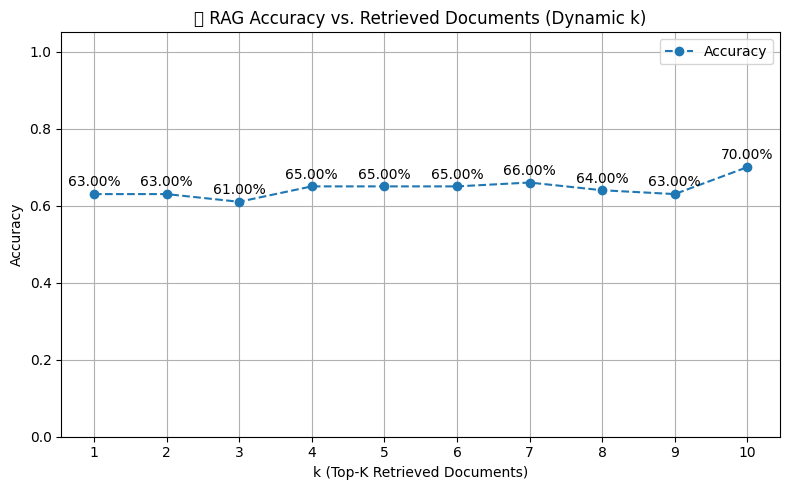

In [137]:
plot_accuracy_comparison(fixed_results)

In [138]:
def evaluate_multiple_k(dataset, k_values, n_questions=10, threshold=0.75, seed=42):
    all_results = {}

    for k in k_values:
        print(f"\n=== Evaluating for k = {k} ===\n")
        results = evaluate_rag_agent_parallel(
            dataset,
            k=k,
            n_questions=n_questions,
            threshold=threshold,
            seed=seed,
        )
        all_results[k] = results["logs"]  # store per-question results
    return all_results



import pandas as pd

def build_correctness_matrix(results_by_k):
    # results_by_k: {k: [logs]}
    matrix = []

    for k, logs in results_by_k.items():
        for log in logs:
            matrix.append({
                "question_idx": log["index"],
                "k": k,
                "status": log["status"]
            })

    df = pd.DataFrame(matrix)
    df["correct"] = df["status"] == "correct"
    return df


import seaborn as sns
import matplotlib.pyplot as plt

def plot_correct_k_heatmap(correctness_df):
    pivot = correctness_df.pivot(index="question_idx", columns="k", values="correct")
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, cmap="Greens", cbar=True, annot=True, fmt=".0f")
    plt.title("✅ Correct Answers per Question across Different k Values")
    plt.xlabel("k")
    plt.ylabel("Question Index")
    plt.tight_layout()
    plt.show()



k_values = list(range(1, 11))
results_by_k = evaluate_multiple_k(hotpot_qa_dataset, k_values=k_values, n_questions=20, threshold=0.8)




=== Evaluating for k = 1 ===


🔍 Evaluating RAG Agent (with fixed k=1)



Evaluating: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]



[0] ❌ INCORRECT
Question: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Prediction: Not provided.
Ground Truth: flotilla
Similarity Score: 0.7494
k used: 1 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Group Captain Cecil Chaudhry (27 August 1941 – 13 April 2012) was a Pakistani academic, human rights activist, and veteran fighter pilot.  As a Flight Lieutenant, he fought in the Indo-Pakistani war of 1965 and later, as a Squadron Leader, in the Indo-Pakistani War of 1971.  During the 1965 war, Chaudhry and three other pilots, under the leadership of Wing Commander Anwar Shamim, attacked the Amritsar Radar Station in a difficult operation.  He was awarded the Sitara-e-Jurat (Star of Courage) for his actions during that mission.




Evaluating: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]



[0] ❌ INCORRECT
Question: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Prediction: Not provided.
Ground Truth: flotilla
Similarity Score: 0.7493
k used: 2 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Group Captain Cecil Chaudhry (27 August 1941 – 13 April 2012) was a Pakistani academic, human rights activist, and veteran fighter pilot.  As a Flight Lieutenant, he fought in the Indo-Pakistani war of 1965 and later, as a Squadron Leader, in the Indo-Pakistani War of 1971.  During the 1965 war, Chaudhry and three other pilots, under the leadership of Wing Commander Anwar Shamim, attacked the Amritsar Radar Station in a difficult operation.  He was awarded the Sitara-e-Jurat (Star of Courage) for his actions during that mission.

C

Evaluating: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]



[0] ✅ CORRECT
Question: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Prediction: Flight Lieutenant
Ground Truth: flotilla
Similarity Score: 0.8463
k used: 3 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Group Captain Cecil Chaudhry (27 August 1941 – 13 April 2012) was a Pakistani academic, human rights activist, and veteran fighter pilot.  As a Flight Lieutenant, he fought in the Indo-Pakistani war of 1965 and later, as a Squadron Leader, in the Indo-Pakistani War of 1971.  During the 1965 war, Chaudhry and three other pilots, under the leadership of Wing Commander Anwar Shamim, attacked the Amritsar Radar Station in a difficult operation.  He was awarded the Sitara-e-Jurat (Star of Courage) for his actions during that mission.


Evaluating: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]



[0] ❌ INCORRECT
Question: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Prediction: Not mentioned.
Ground Truth: flotilla
Similarity Score: 0.7493
k used: 4 (Fixed k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Group Captain Cecil Chaudhry (27 August 1941 – 13 April 2012) was a Pakistani academic, human rights activist, and veteran fighter pilot.  As a Flight Lieutenant, he fought in the Indo-Pakistani war of 1965 and later, as a Squadron Leader, in the Indo-Pakistani War of 1971.  During the 1965 war, Chaudhry and three other pilots, under the leadership of Wing Commander Anwar Shamim, attacked the Amritsar Radar Station in a difficult operation.  He was awarded the Sitara-e-Jurat (Star of Courage) for his actions during that mission.



Evaluating:  95%|█████████▌| 19/20 [00:06<00:00,  2.83it/s]


KeyboardInterrupt: 

/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/460336443.py:47: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/Users/yarinshitrit/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


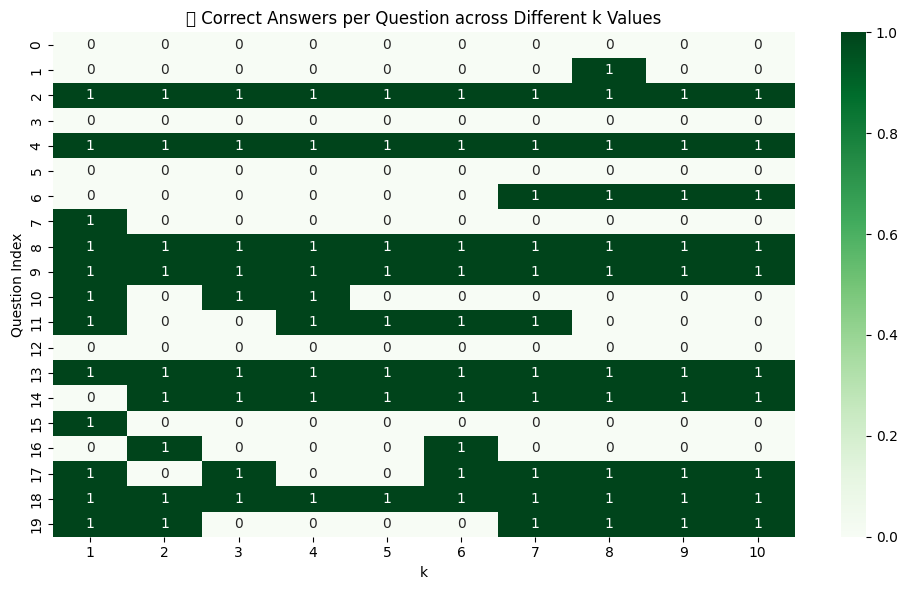

In [139]:
correctness_df = build_correctness_matrix(results_by_k)
plot_correct_k_heatmap(correctness_df)

# 🧪 Approaches to Dynamically Determine `k` in Vector Similarity Search

Choosing the right number of documents (`k`) to retrieve for a given query is crucial for balancing relevance, efficiency, and downstream model performance in RAG systems.

Here we explore three statistically-motivated techniques for determining `k` dynamically based on the **distribution of similarity scores** between the query and candidate documents.

---

## 1. Benjamini–Hochberg Procedure (False Discovery Rate Control)

### 🔍 Overview
The **Benjamini–Hochberg (BH) procedure** is a statistical method for **controlling the False Discovery Rate (FDR)** — the expected proportion of false positives among the selected items. It is typically used in multiple hypothesis testing scenarios.

In the context of vector similarity search:
- Each document can be treated as a "hypothesis" (i.e., "Is this document relevant?").
- We compute **p-values** (or a proxy derived from similarity scores) for each document.
- BH controls the expected rate of false positives among the selected top-*k* documents.

### ⚙️ How it works
1. Convert similarity scores into pseudo p-values (e.g., via ranking or null distribution assumptions).
2. Sort these p-values in ascending order: $( p_1, p_2, ..., p_n )$
3. For each p-value, check:
$
p_i \leq \frac{i}{n} \cdot \alpha
$


   where $\alpha \$ is the desired FDR (e.g., 0.05).
4. Select the **largest `i`** that satisfies the inequality — set `k = i`.

### ✅ Pros
- More power than conservative tests like Bonferroni.
- Controls false discovery rather than per-test error.
- Adapts naturally to the number and quality of candidate documents.

---

## 2. Bonferroni Correction (Family-Wise Error Rate Control)

### 🔍 Overview
The **Bonferroni correction** is a conservative method to control the **Family-Wise Error Rate (FWER)** — the probability of making **any** false discovery.

It is stricter than BH and is often used when **false positives must be avoided at all costs**.

### ⚙️ How it works
1. Convert similarity scores into pseudo p-values.
2. Adjust the threshold using:
   $
   \alpha' = \frac{\alpha}{n}
   $
   where $ n $ is the total number of documents and $\alpha$ is the desired overall error rate (e.g., 0.05).
3. Select all documents with $p_i \leq \alpha'$
4. Set `k` as the number of documents that meet the criterion.

### ⚠️ Caveats
- Very conservative: often results in **low `k`** or even `k=0`, especially when many candidates are noisy or weakly similar.
- Better suited for high-stakes applications where **false positives are expensive**.

---

## 3. Higher Criticism Thresholding

### 🔍 Overview
**Higher Criticism (HC)** is a powerful method for detecting **sparse and weak signals** in large-scale testing problems. It is especially effective when:
- Only a small fraction of documents are truly relevant.
- Their similarity scores are only **slightly stronger than noise**.

Originally proposed by Donoho & Jin (2008), HC finds an **optimal threshold** by balancing signal detection and noise suppression.

📄 [PNAS Article](https://www.pnas.org/doi/abs/10.1073/pnas.0807471105)

### ⚙️ How it works
1. Convert similarity scores into z-scores or p-values under a null model.
2. Compute the **Higher Criticism statistic** for each ordered p-value:
   $
   HC(i) = \frac{\sqrt{n} \left( \frac{i}{n} - p_i \right)}{\sqrt{p_i (1 - p_i)}}
   $
3. Find the **index `i` with the maximum HC value** → this index indicates the optimal threshold.
4. Set `k = i`, selecting the top-`k` documents as relevant.

### 🚀 Advantages
- Adaptive to sparse signal settings.
- Theoretically powerful under weak signal conditions.
- Can outperform both BH and Bonferroni when only a few strong matches exist.

---

## 📊 Summary of Methods

| Method                    | Controls           | Conservative? | Adaptive? | Best Use Case                                  |
|--------------------------|--------------------|---------------|-----------|------------------------------------------------|
| Benjamini-Hochberg (BH)  | False Discovery Rate (FDR) | ❌ No         | ✅ Yes    | General-purpose; balances false positives      |
| Bonferroni Correction     | Family-Wise Error Rate (FWER) | ✅ Yes        | ❌ No     | High-stakes tasks; requires strict precision   |
| Higher Criticism (HC)    | Sparse Signal Detection | ⚠ Depends     | ✅ Yes    | Sparse, noisy data; detecting weak signals     |

---



In [140]:
from datasets import load_dataset
from typing import List

def load_unrelated_corpus_from_dailydialog() -> List[str]:
    """
    Load unrelated text samples from the DailyDialog dataset to build the null distribution.
    
    Returns:
        A list of utterances from the DailyDialog dataset.
    """
    dataset = load_dataset("daily_dialog")
    # Each sample has a 'dialog' key, which is a list of utterances
    corpus_texts = [utterance for d in dataset["train"] for utterance in d["dialog"] if utterance.strip()]
    return corpus_texts


In [141]:
def generate_null_distribution_against_hotpotqa(
    unrelated_questions: List[str],
    hotpot_embeddings: List[List[float]],
    n_trials: int = 100,
    k: int = 20
) -> np.ndarray:
    null_scores = []
    for _ in range(n_trials):
        question = np.random.choice(unrelated_questions)
        q_emb = get_embedding(question)

        # Compare question to *real HotpotQA documents*
        sims = cosine_similarity([q_emb], hotpot_embeddings)[0]
        top_k_sims = np.sort(sims)[::-1][:k]

        null_scores.extend(top_k_sims)
    return np.array(null_scores)

In [143]:
daily_dialog_corpus = load_unrelated_corpus_from_dailydialog()

null_distribution = generate_null_distribution_against_hotpotqa(daily_dialog_corpus, hotpot_embeddings)

/opt/homebrew/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [144]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def higher_criticism(
    question_emb,
    doc_embs,
    null_distribution,
    alpha=0.05,
    max_k: int = 10
) -> int:
    # Step 1: Compute cosine similarities
    similarities = cosine_similarity([question_emb], doc_embs)[0]
    sorted_similarities = np.sort(similarities)[::-1]
    n = min(max_k, len(sorted_similarities))

    # Step 2: Convert similarities to empirical p-values using the null distribution
    p_values = np.array([
        (null_distribution >= sim).mean() for sim in sorted_similarities[:n]
    ])

    # Step 3: Clip extreme values for stability
    p_values = np.clip(p_values, 1e-10, 1 - 1e-10)

    # Step 4: Compute the HC statistic for each p-value
    i = np.arange(1, n + 1)
    expected = i / n
    hc_stats = np.sqrt(n) * (expected - p_values) / np.sqrt(p_values * (1 - p_values))

    # Step 5: Return the index with the maximum HC value
    best_k = int(np.argmax(hc_stats)) + 1
    return best_k


In [145]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def bonferroni_correction(
    question_emb,
    doc_embs,
    null_distribution,
    alpha=0.05,
    max_k: int = 10
):
    similarities = cosine_similarity([question_emb], doc_embs)[0]
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_similarities = similarities[sorted_indices]

    alpha_prime = alpha / len(sorted_similarities)  # Bonferroni correction

    # Compute pseudo p-values: proportion of null scores ≥ observed
    pseudo_pvals = np.array([
        np.mean(null_distribution >= sim) for sim in sorted_similarities
    ])

    # Select all documents whose p-value ≤ corrected alpha
    valid_mask = pseudo_pvals <= alpha_prime
    k = int(np.sum(valid_mask))

    # Always return at least 1 document
    k = min(max(k, 1), max_k)

    return k


In [146]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def benjamini_hochberg(
    question_emb,
    doc_embs,
    null_distribution,
    alpha=0.05,
    max_k: int = 10
):
    n_docs = len(doc_embs)
    similarities = cosine_similarity([question_emb], doc_embs)[0]

    # Convert similarity to p-values based on the null distribution
    p_values = np.array([
        np.mean(null_distribution >= sim) for sim in similarities
    ])

    # Sort p-values and track original indices
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]

    k_selected = 0
    for i, p in enumerate(sorted_p_values, start=1):
        threshold = (i / n_docs) * alpha
        if p <= threshold:
            k_selected = i

    # Limit by max_k
    k_selected = min(k_selected, max_k)
    return max(k_selected,1)


In [147]:
dynamic_results = []

# Run dynamic-k evaluation
for dynamic_k_function in [higher_criticism, bonferroni_correction, benjamini_hochberg]:
    result = evaluate_rag_agent_parallel(
        dataset=short_answer_dataset,
        n_questions=n_questions,
        dynamic_k_function=dynamic_k_function,
        null_distribution=null_distribution,
        threshold=0.8,
        seed=seed,
        selected_indices=selected_indices,
        max_workers=10
    )
    result["method"] = dynamic_k_function.__name__
    dynamic_results.append(result)



🔍 Evaluating RAG Agent (with Dynamic k: higher_criticism)



Evaluating: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 4 (Dynamic k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepbur

Evaluating: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]



[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7659
k used: 4 (Dynamic k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepbur

Evaluating: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


[0] ❌ INCORRECT
Question: Which of the role of Cindy Robinson was an anime adaptation of the "Blue Dragon" video game series?
Prediction: Zola
Ground Truth: Blue Dragon
Similarity Score: 0.7658
k used: 4 (Dynamic k)
📨 Full Prompt:
SYSTEM:
You are a Retrieval-Augmented Generation (RAG) agent. Answer only using the provided context below. Respond with concise. accurate answers. Use only 1-2 words in your answer.

Context:
Cindy Robinson is an American voice actress who voices in anime, cartoons and video games.  Some of her major roles are Makoto Nanaya and Gii from the "Blazblue" series, Betty Boop in commercials, Queen Beryl in "Sailor Moon", Chitose Nanbu in "Ah My Buddha", Kukaku Shiba, Jinta Hanakari (kid) and Kiyone Kotetsu in "Bleach", Zola in the "Blue Dragon" series, and Amy Rose in the "Sonic the Hedgehog" series.

Blue Dragon (ブルードラゴン , Burū Doragon ) is an anime adaptation of the "Blue Dragon" video game series.

Blue Dragon: Awakened Shadow (Japanese: ブルードラゴン 異界の巨獣 , Hepbur

In [148]:
import matplotlib.pyplot as plt

def plot_all_dynamic_k_results(dynamic_results):
    """
    Visualize dynamic k and correctness for multiple dynamic evaluation runs in a single combined plot.

    Args:
        dynamic_results (list of dict): Each entry is from evaluate_rag_agent_parallel and must contain 'logs' and 'method'.
    """
    plt.figure(figsize=(12, 6))

    color_map = {
        "Bonferroni": "blue",
        "Higher Criticism": "orange",
        "Benjamini-Hochberg": "purple",
    }

    marker_map = {
        "correct": "o",
        "incorrect": "x",
    }

    for result in dynamic_results:
        logs = result["logs"]
        ks = [log["k"] for log in logs]
        correctness = [log["status"] == "correct" for log in logs]
        xs = list(range(len(logs)))
        method_name = result.get("method", "Dynamic")

        color = color_map.get(method_name, "gray")
        correct_xs = [x for x, c in zip(xs, correctness) if c]
        correct_ks = [k for k, c in zip(ks, correctness) if c]
        incorrect_xs = [x for x, c in zip(xs, correctness) if not c]
        incorrect_ks = [k for k, c in zip(ks, correctness) if not c]

        plt.scatter(correct_xs, correct_ks, color=color, marker="o", s=100, label=f"{method_name} ✅")
        plt.scatter(incorrect_xs, incorrect_ks, color=color, marker="x", s=100, label=f"{method_name} ❌")

    # Format axes
    all_ks = [log["k"] for result in dynamic_results for log in result["logs"]]
    max_k = max(all_ks)
    min_k = min(all_ks)
    n_questions = len(dynamic_results[0]["logs"])

    plt.yticks(range(min_k, max_k + 1))
    plt.xticks(range(n_questions), [str(i + 1) for i in range(n_questions)], rotation=45)

    plt.xlabel("Question Index")
    plt.ylabel("Dynamic k used (integer)")
    plt.title("📊 Dynamic k per Question – Combined View for All Methods")
    plt.grid(True)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/2937882166.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/2937882166.py:53: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/2937882166.py:53: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/Users/yarinshitrit/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yarinshitrit/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yarinshitrit/Library/Python/3.11/lib

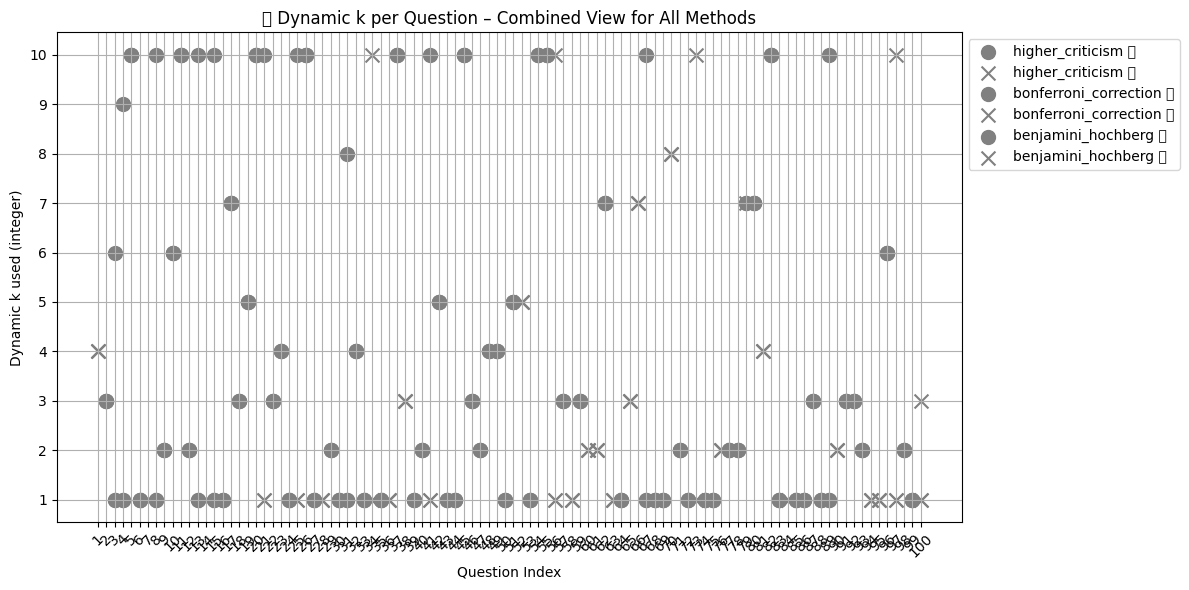

In [149]:
plot_all_dynamic_k_results(dynamic_results)

In [150]:
import matplotlib.pyplot as plt

def plot_dynamic_vs_fixed_accuracy(dynamic_results, fixed_results):
    """
    Plots total accuracy of multiple dynamic k strategies vs fixed-k RAG runs.

    Args:
        dynamic_results (list of dict): Each result from evaluate_rag_agent_parallel
                                        with a 'method' and 'accuracy' key.
        fixed_results (list of dict): Fixed-k results with 'used_k' and 'accuracy'.
    """
    # Fixed-k values and accuracies
    fixed_ks = [res["used_k"] for res in fixed_results]
    fixed_accuracies = [res["accuracy"] for res in fixed_results]

    # Style map for dynamic methods (no gray!)
    method_styles = {
        "Bonferroni": {"color": "royalblue", "marker": "o"},
        "Higher Criticism": {"color": "darkorange", "marker": "s"},
        "Benjamini-Hochberg": {"color": "mediumvioletred", "marker": "D"},
        "Other": {"color": "teal", "marker": "X"}
    }

    plt.figure(figsize=(12, 6))

    # Plot fixed-k baseline
    plt.plot(
        fixed_ks, fixed_accuracies,
        color="black", linestyle='--', marker='^', markersize=8,
        label="Fixed k (baseline)"
    )

    # Plot dynamic methods
    for i, result in enumerate(dynamic_results):
        method = result.get("method", f"Dynamic {i+1}")
        acc = result["accuracy"]
        style = method_styles.get(method, method_styles["Other"])

        x_pos = max(fixed_ks) + 1 + i  # avoid overlap with fixed k values

        plt.scatter(
            x_pos, acc,
            color=style["color"],
            edgecolor="black",
            s=180,
            marker=style["marker"],
            label=f"{method} (Accuracy: {acc:.2%})"
        )

        plt.axhline(acc, color=style["color"], linestyle=":", linewidth=1.5, alpha=0.7)

    # Axis and ticks
    xticks = fixed_ks + [max(fixed_ks) + 1 + i for i in range(len(dynamic_results))]
    xticklabels = [str(k) for k in fixed_ks] + [res["method"] for res in dynamic_results]

    plt.xticks(xticks, xticklabels, rotation=30)
    plt.xlabel("k (Fixed values and Dynamic Methods)")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.title("📊 RAG Accuracy: Fixed-k vs. Dynamic-k Strategies")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/3323364869.py:63: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


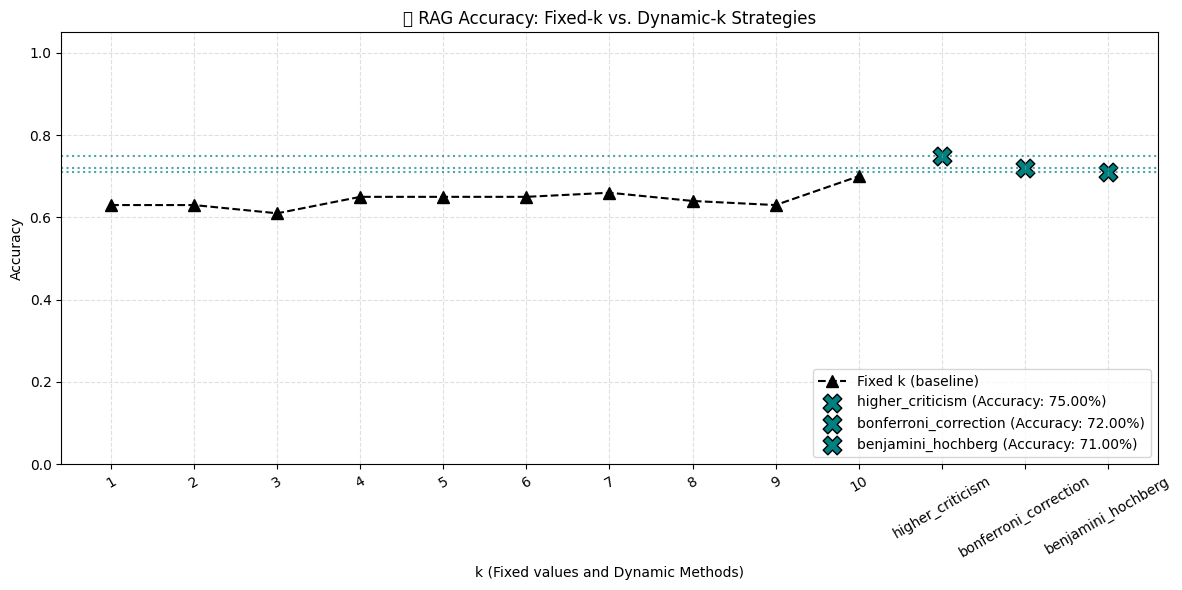

In [151]:
# Plot
plot_dynamic_vs_fixed_accuracy(dynamic_results, fixed_results)

In [184]:
import matplotlib.pyplot as plt

# Updated cost per 1K input tokens
COST_PER_1K_TOKENS = 0.005

def plot_tokens_cost_with_accuracy(fixed_k_results, dynamic_k_results):
    """
    Plot total tokens and estimated cost for both fixed-k and multiple dynamic-k runs,
    with accuracy and cost shown above each point. Cost Y-axis is spread for visual clarity.
    """
    fixed_ks = [res["used_k"] for res in fixed_k_results]
    fixed_total_tokens = []
    fixed_costs = []
    fixed_accuracies = []

    for res in fixed_k_results:
        tokens = sum(len(doc["content"].split()) for log in res["logs"] for doc in log["retrieved_docs"])
        cost = tokens / 1000 * COST_PER_1K_TOKENS
        fixed_total_tokens.append(tokens)
        fixed_costs.append(cost)
        fixed_accuracies.append(res["accuracy"])

    dynamic_tokens = []
    dynamic_costs = []
    dynamic_labels = []
    dynamic_accuracies = []
    dynamic_xs = list(range(fixed_ks[-1] + 1, fixed_ks[-1] + 1 + len(dynamic_k_results)))

    for res in dynamic_k_results:
        logs = res["logs"]
        method = res.get("method", "Dynamic")
        tokens = sum(len(doc["content"].split()) for log in logs for doc in log["retrieved_docs"])
        cost = tokens / 1000 * COST_PER_1K_TOKENS
        accuracy = res["accuracy"]

        dynamic_tokens.append(tokens)
        dynamic_costs.append(cost)
        dynamic_accuracies.append(accuracy)
        dynamic_labels.append(method)

    all_xticks = fixed_ks + dynamic_xs
    all_xtick_labels = [str(k) for k in fixed_ks] + dynamic_labels

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("k (Fixed + Dynamic Methods)")
    ax1.set_ylabel("Total Tokens", color="blue")
    ax1.plot(fixed_ks, fixed_total_tokens, marker='x', linestyle='-', color='blue', label="Fixed-k: Tokens")
    ax1.scatter(dynamic_xs, dynamic_tokens, color='blue', marker='x', s=80, label="Dynamic-k: Tokens")

    for x, y, acc in zip(fixed_ks, fixed_total_tokens, fixed_accuracies):
        ax1.text(x, y + 250, f"{acc:.2%}", ha="center", va="bottom", fontsize=9, color='blue')
    for x, y, acc in zip(dynamic_xs, dynamic_tokens, dynamic_accuracies):
        ax1.text(x, y + 250, f"{acc:.2%}", ha="center", va="bottom", fontsize=9, color='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Estimated Cost (USD)", color="orange")
    ax2.plot(fixed_ks, fixed_costs, marker='o', linestyle='--', color='orange', label="Fixed-k: Cost")
    ax2.scatter(dynamic_xs, dynamic_costs, color='orange', marker='*', s=150, label="Dynamic-k: Cost")

    for x, y in zip(fixed_ks, fixed_costs):
        ax2.text(x, y + 0.01, f"${y:.4f}", ha="center", va="bottom", fontsize=9, color='orange')
    for x, y in zip(dynamic_xs, dynamic_costs):
        ax2.text(x, y + 0.01, f"${y:.4f}", ha="center", va="bottom", fontsize=9, color='orange')

    # Make cost y-axis more spread to prevent overlap
    max_cost = max(fixed_costs + dynamic_costs)
    ax2.set_ylim(0, max_cost * 1.6)

    ax1.set_xticks(all_xticks)
    ax1.set_xticklabels(all_xtick_labels, rotation=30, ha='right')

    ax1.grid(True)
    fig.legend(loc="upper left", bbox_to_anchor=(0.05, 0.95), bbox_transform=ax1.transAxes)
    plt.title("📊 Total Tokens and Cost (Fixed vs Dynamic k)\nAccuracy and Cost shown above each point")
    plt.tight_layout()
    plt.show()


/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/2012802240.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


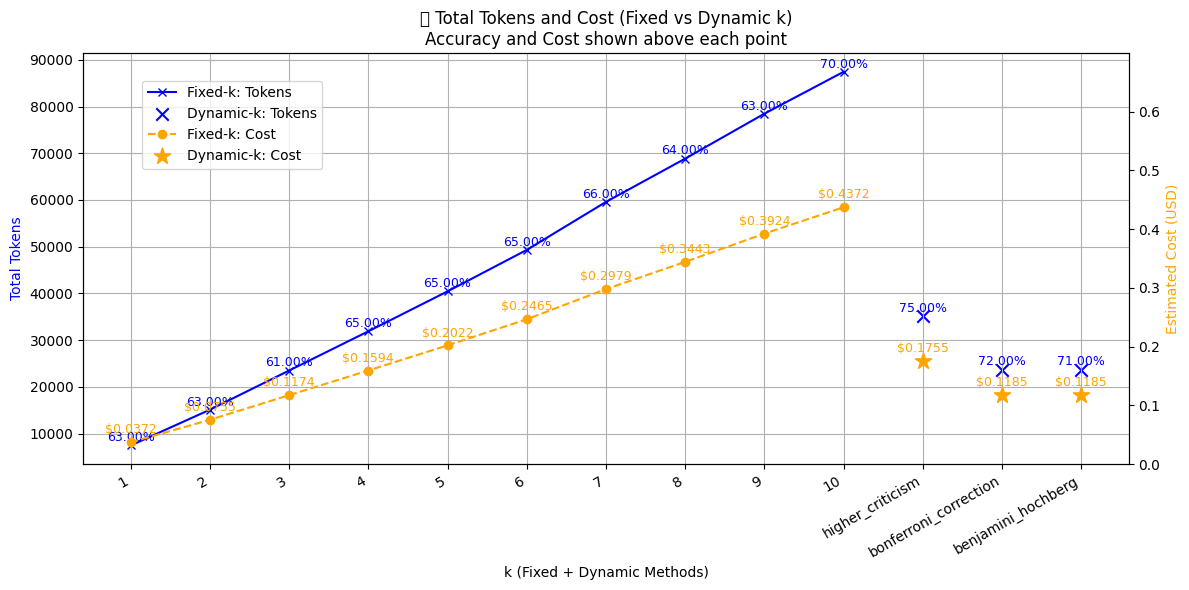

In [185]:
plot_tokens_cost_with_accuracy(fixed_results, dynamic_results)

/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/1835197150.py:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


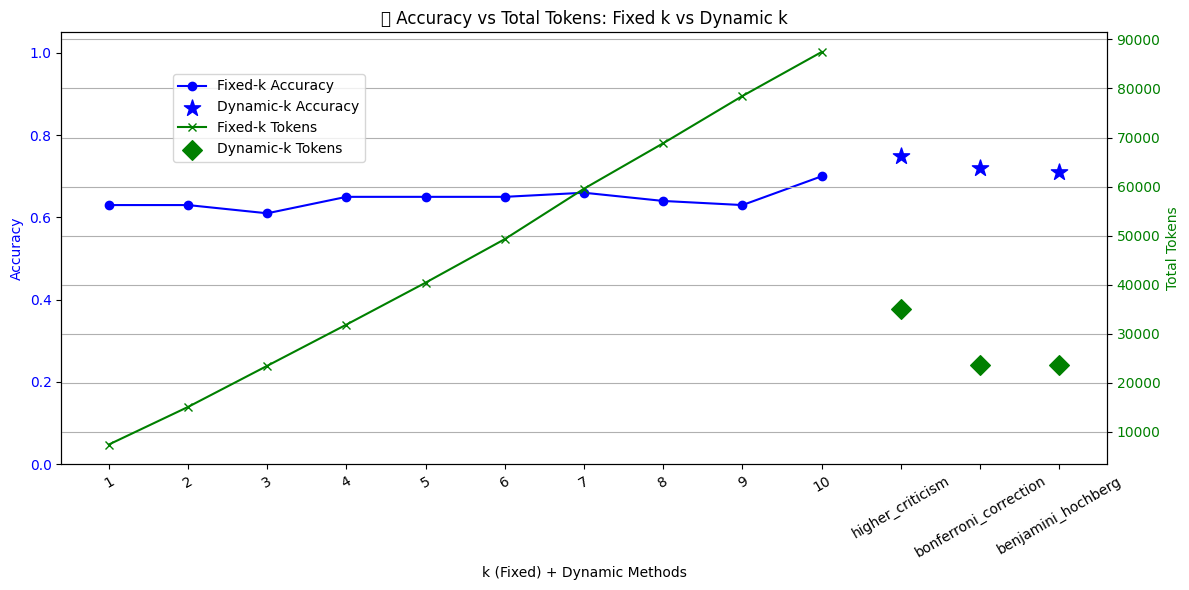

In [188]:
plot_accuracy_and_tokens_comparison(fixed_results, dynamic_results)

In [196]:
import matplotlib.pyplot as plt

def plot_accuracy_per_token_ranking(fixed_k_results, dynamic_k_results):
    """
    Plot ranking of all methods (fixed and dynamic) by accuracy per 1K tokens.

    Args:
        fixed_k_results (list of dict): Each with 'used_k', 'accuracy', and 'logs'
        dynamic_k_results (list of dict): Each with 'method', 'accuracy', and 'logs'
    """
    method_stats = []

    # Fixed-k methods
    for res in fixed_k_results:
        total_tokens = sum(len(doc["content"].split()) for log in res["logs"] for doc in log["retrieved_docs"])
        acc = res["accuracy"]
        acc_per_1k = acc / (total_tokens / 1000) if total_tokens > 0 else 0
        method_stats.append({
            "method": f"Fixed k={res['used_k']}",
            "accuracy": acc,
            "tokens": total_tokens,
            "acc_per_1k_tokens": acc_per_1k
        })

    # Dynamic-k methods
    for res in dynamic_k_results:
        total_tokens = sum(len(doc["content"].split()) for log in res["logs"] for doc in log["retrieved_docs"])
        acc = res["accuracy"]
        acc_per_1k = acc / (total_tokens / 1000) if total_tokens > 0 else 0
        method_stats.append({
            "method": f"Dynamic ({res['method']})",
            "accuracy": acc,
            "tokens": total_tokens,
            "acc_per_1k_tokens": acc_per_1k
        })

    # Sort by efficiency (accuracy per 1k tokens)
    method_stats.sort(key=lambda x: x["acc_per_1k_tokens"], reverse=True)

    # Extract data
    methods = [stat["method"] for stat in method_stats]
    efficiencies = [stat["acc_per_1k_tokens"] for stat in method_stats]
    accuracies = [stat["accuracy"] for stat in method_stats]

    # Plot
    plt.figure(figsize=(11, len(methods) * 0.6))
    bars = plt.barh(methods, efficiencies, color='mediumseagreen')

    # Annotate bars
    for bar, eff, acc in zip(bars, efficiencies, accuracies):
        plt.text(bar.get_width() + 0.0015, bar.get_y() + bar.get_height() / 2,
                 f"{eff:.3f} | {acc:.1%}", va='center', fontsize=9)

    # Highlight best
    best = method_stats[0]
    plt.title(f"🏆 Accuracy per 1K Tokens — Best: {best['method']} ({best['acc_per_1k_tokens']:.3f} | {best['accuracy']:.1%})",
              fontsize=13, weight="bold", pad=15)

    plt.xlabel("Accuracy / 1K Tokens Used")
    plt.gca().invert_yaxis()  # Best method on top
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


/var/folders/yg/0gjp0gb57t37x2mg74mx1d440000gn/T/ipykernel_12526/931165512.py:62: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()


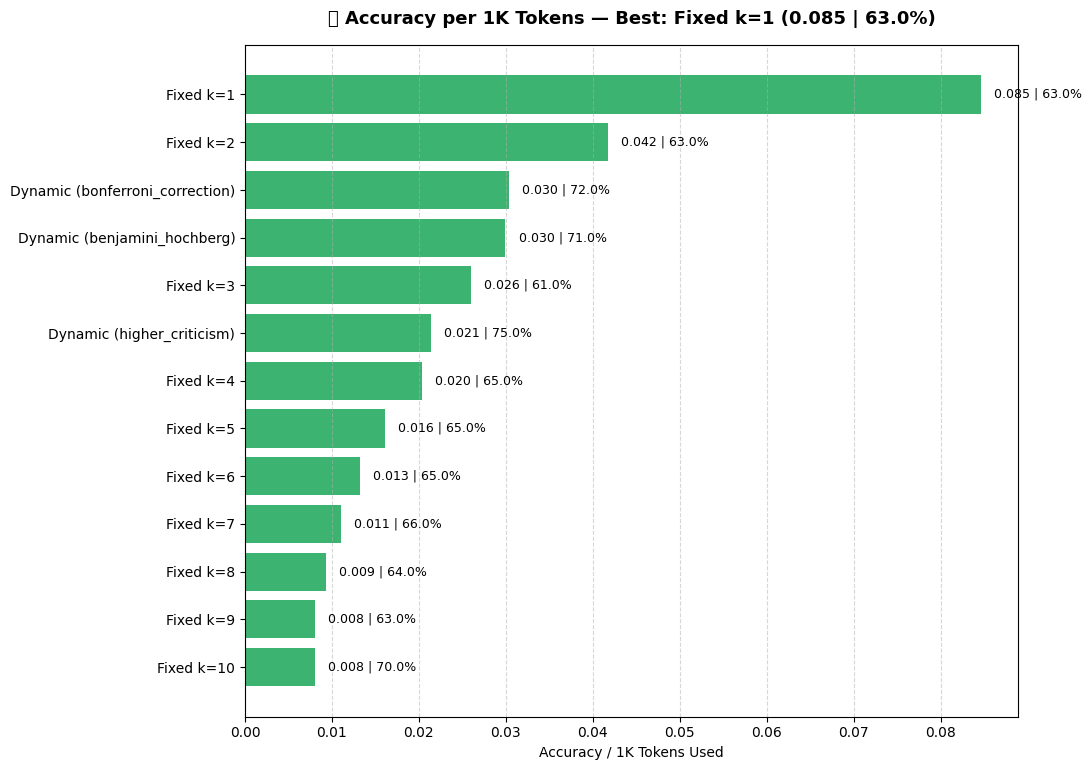

In [198]:
plot_accuracy_per_token_ranking(fixed_results, dynamic_results)